# Análisis de datos de COVID-19 a un mes de sana distancia en México

En México iniciaron formalmente las medidas de distanciamiento social el 23 de marzo de 2020. Transcurrido poco más de un mes, es importante tener alguna idea de cómo están evolucionando las cosas, más allá del dato diario de casos y las defunciones. Por ello decidí hacer un análisis de la base de casos estudiados al 29 de abril de 2020 que publica la Secretaría de Salud en su página de datos abiertos.

https://www.gob.mx/salud/documentos/datos-abiertos-152127?idiom=es


## Importación de librerías y parámetros iniciales

In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, date, timedelta
import locale
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

locale.setlocale(locale.LC_ALL, 'es-mx')
sns.set()
sns.set_style('white')
%matplotlib inline

## Lectura de archivos de datos
Se obtienen datos de la página de datos abiertos de la Secretaría de Salud de México, así como del Consejo Nacional de Población para los datos de población de cada estado de la república.

In [2]:
url = 'http://187.191.75.115/gobmx/salud/datos_abiertos/historicos/datos_abiertos_covid19_29.04.2020.zip'
nombre = 'datos_abiertos_covid19_29.04.2020.zip'

r = requests.get(url, allow_redirects=True)
with open(nombre, 'wb') as archivo:
    archivo.write(r.content)

In [3]:
casos_totales = pd.read_csv(nombre, encoding='latin-1')
diccionario = pd.read_excel('Descriptores_0419.xlsx', encoding='utf-8')

Se crea un diccionario con los nombres de las entidades federativas a partir del archivo de catálogos de los datos abiertos.

In [4]:
catalogo_entidades = pd.read_excel('Catalogos_0412.xlsx',encoding='utf-8',sheet_name='Catálogo de ENTIDADES')
entidades = dict(zip(catalogo_entidades['CLAVE_ENTIDAD'],catalogo_entidades['ENTIDAD_FEDERATIVA']))

Se crea un diccionario con las instituciones de origen de los casos.

In [5]:
catalogo_instituciones = pd.read_excel('Catalogos_0412.xlsx',encoding='utf-8',sheet_name='Catálogo SECTOR')
instituciones = dict(zip(catalogo_instituciones['CLAVE'],catalogo_instituciones['DESCRIPCIÓN']))

Se genera un diccionario con las poblaciones estimadas por el Consejo Nacional de Población para el inicio del año 2020.

In [6]:
poblacion_entidades = pd.read_csv('pob_ini_proyecciones.csv', encoding='utf-8')
poblacion_entidades = poblacion_entidades[poblacion_entidades['AÑO'] == 2020]\
                      .groupby(poblacion_entidades['ENTIDAD'])['POBLACION'].sum()

# Claves para homologar con el diccionario de nombres de entidades
claves = [1,2,3,4,7,8,9,5,6,10,11,12,13,14,16,17,15,18,19,20,21,22,23,36,24,25,26,27,28,29,30,31,32]

poblacion_entidades = dict(zip(claves, poblacion_entidades))

## Limpieza de datos

### Información general de la estructura de datos
No faltan datos. Hay 1 atributo numérico (edad), 27 categóricos y 7 alfanuméricos (identificación del registro, 4 fechas, país de nacionalidad y país de origen)

In [7]:
casos_totales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81912 entries, 0 to 81911
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   FECHA_ACTUALIZACION  81912 non-null  object
 1   ID_REGISTRO          81912 non-null  object
 2   ORIGEN               81912 non-null  int64 
 3   SECTOR               81912 non-null  int64 
 4   ENTIDAD_UM           81912 non-null  int64 
 5   SEXO                 81912 non-null  int64 
 6   ENTIDAD_NAC          81912 non-null  int64 
 7   ENTIDAD_RES          81912 non-null  int64 
 8   MUNICIPIO_RES        81912 non-null  int64 
 9   TIPO_PACIENTE        81912 non-null  int64 
 10  FECHA_INGRESO        81912 non-null  object
 11  FECHA_SINTOMAS       81912 non-null  object
 12  FECHA_DEF            81912 non-null  object
 13  INTUBADO             81912 non-null  int64 
 14  NEUMONIA             81912 non-null  int64 
 15  EDAD                 81912 non-null  int64 
 16  NACI

### Análisis de las columnas de nacionalidad y país de origen

En 81,734 registros (99.8%) de la columna PAIS_ORIGEN se tiene el valor 99. De acuerdo con el diccionario de datos, esta columna identifica el país desde el que viajó la persona con destino a México, la clave 99 significa que se desconoce. Por lo anterior, se omitirá la columna país de origen para el análisis.

In [8]:
casos_totales['PAIS_ORIGEN'].value_counts()

99                           81734
Estados Unidos de América       29
Otro                            24
República de Honduras           18
El Salvador                     16
Colombia                        16
Venezuela                       14
Cuba                            13
Guatemala                       11
Belice                           7
Chile                            5
España                           3
Nicaragua                        3
Haití                            2
Bolivia                          2
Ecuador                          2
Canadá                           2
Japón                            1
Perú                             1
Alemania                         1
Costa de Marfil                  1
Brasil                           1
Egipto                           1
China                            1
Irlanda                          1
Grecia                           1
Eritrea                          1
Camerún                          1
Name: PAIS_ORIGEN, d

En 80,753 registros (98.6%) de la columna PAIS_NACIONALIDAD se tiene el valor México. Los datos de otros páises no son representativos, por lo que se omitirá la columna país de nacionalidad para el análisis.

In [9]:
casos_totales['PAIS_NACIONALIDAD'].value_counts()

MÃ©xico                       80753
Estados Unidos de AmÃ©rica      329
EspaÃ±a                          85
Colombia                         83
Venezuela                        71
                              ...  
Zimbabwe                          1
Commonwealth de Dominica          1
Bosnia y Herzegovina              1
Austria                           1
RepÃºblica de Mauricio            1
Name: PAIS_NACIONALIDAD, Length: 71, dtype: int64

### Análisis de atributos binarios
Existen 17 atributos binarios y en 15 de ellos la mayoría de los registros tienen la información. En el atributo MIGRANTE se desconoce el dato en 99.4% de los casos y en el atributo OTRO_CASO (que define si se tuvo contacto con otro caso diagnosticado) no se conoce el dato en 37.8% de los casos. Se eliminará el atributo  MIGRANTE.

In [10]:
funcion = lambda x: x['FORMATO O FUENTE'].strip() == 'CATÁLOGO: SI_ NO'
atributos_binarios = list(diccionario[diccionario.apply(funcion, axis=1)]['NOMBRE DE VARIABLE'].values)

# Elimina inconsistencia con el diccionario de atributos
casos_totales.rename(columns={'OTRA_COM':'OTRAS_COM'}, inplace=True)

for atributo in atributos_binarios:
    porcentaje_desc = (casos_totales[atributo] >97).sum() / len(casos_totales[atributo])
    print(f'{atributo} {porcentaje_desc:>.1%}')

INTUBADO 0.0%
NEUMONIA 0.0%
EMBARAZO 0.3%
HABLA_LENGUA_INDIG 1.9%
DIABETES 0.4%
EPOC 0.4%
ASMA 0.4%
INMUSUPR 0.5%
HIPERTENSION 0.4%
OTRAS_COM 0.6%
CARDIOVASCULAR 0.4%
OBESIDAD 0.4%
RENAL_CRONICA 0.4%
TABAQUISMO 0.4%
OTRO_CASO 37.8%
MIGRANTE 99.5%
UCI 0.0%



### Análisis de atributos con catálogo

Existen 10 atributos con catálogo y en todos se tiene la información de casi todos los registros. El atributo de ENTIDAD_NAC no es relevante para el análisis, por lo que se eliminará.

In [11]:
funcion = lambda x: re.match('CAT[AÁ]L[OÓ]GO:',x['FORMATO O FUENTE'][:9]) != None and \
x['NOMBRE DE VARIABLE'] not in atributos_binarios

atributos_catalogo = list(diccionario[diccionario.apply(funcion, axis=1)]['NOMBRE DE VARIABLE'].values)

for atributo in atributos_catalogo:
    if atributo != 'MUNICIPIO_RES':
        porcentaje_desc = (casos_totales[atributo] >96).sum() / len(casos_totales[atributo])
    else:
        porcentaje_desc = (casos_totales[atributo] >996).sum() / len(casos_totales[atributo])
    print(f'{atributo} {porcentaje_desc:>.1%}')

ORIGEN 0.0%
SECTOR 0.7%
ENTIDAD_UM 0.0%
SEXO 0.0%
ENTIDAD_NAC 1.4%
ENTIDAD_RES 0.0%
MUNICIPIO_RES 0.0%
TIPO_PACIENTE 0.0%
NACIONALIDAD 0.0%
RESULTADO 0.0%


### Conversión de las columnas de fecha

In [12]:
columnas_fecha = ['FECHA_INGRESO', 'FECHA_SINTOMAS','FECHA_DEF']
casos_totales[columnas_fecha]
for columna in columnas_fecha:
    casos_totales[columna] = pd.to_datetime(casos_totales[columna], errors = 'coerce', dayfirst=True)

### Determinación de la fecha de actualización

In [13]:
fecha_actualizacion = date.fromisoformat(casos_totales['FECHA_ACTUALIZACION'].unique()[0])

### Elminación de columnas
Se eliminan las columnas PAIS_ORIGEN y MIGRANTE por tener demasiados datos faltantes, PAIS_NACIONALIDAD y ENTIDAD_NAC por no ser relevantes, así como FECHA_ACTUALIZACION, que tiene el mismo valor en todos los registros.

In [14]:
casos_totales.drop(['PAIS_ORIGEN','MIGRANTE','PAIS_NACIONALIDAD',
            'ENTIDAD_NAC', 'FECHA_ACTUALIZACION'], axis=1, inplace=True)

### Conclusiones de la limpieza de datos
La base de datos está completa. No existen datos suficientes para hacer un análisis por país de origen de viaje o condición de migrante. En 37.8% de los casos se desconoce si hubo contacto con otro caso diagnosticado.

## Análisis preliminar de datos

Después de la limpieza de datos, quedan 4 atributos numéricos (edad y 3 fechas), 25 categóricos (16 binarios y 9 de catálogo) y uno alfanumérico (identificación del registro).

In [15]:
casos_totales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81912 entries, 0 to 81911
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID_REGISTRO         81912 non-null  object        
 1   ORIGEN              81912 non-null  int64         
 2   SECTOR              81912 non-null  int64         
 3   ENTIDAD_UM          81912 non-null  int64         
 4   SEXO                81912 non-null  int64         
 5   ENTIDAD_RES         81912 non-null  int64         
 6   MUNICIPIO_RES       81912 non-null  int64         
 7   TIPO_PACIENTE       81912 non-null  int64         
 8   FECHA_INGRESO       81912 non-null  datetime64[ns]
 9   FECHA_SINTOMAS      81912 non-null  datetime64[ns]
 10  FECHA_DEF           2868 non-null   datetime64[ns]
 11  INTUBADO            81912 non-null  int64         
 12  NEUMONIA            81912 non-null  int64         
 13  EDAD                81912 non-null  int64     

Para facilitar el análisis se clasifican los atributos en tres categorías: 2 relativas a la persona (datos sociodemográficos y de existencia de otras conidciones o padecimientos) y 1 relativa al proceso de atención.

In [16]:
atributos_sociodemograficos = ['SEXO', 'ENTIDAD_RES','MUNICIPIO_RES',
                               'EDAD', 'NACIONALIDAD', 'HABLA_LENGUA_INDIG']
atributos_comorbilidad = ['NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
                          'HIPERTENSION', 'OTRAS_COM', 'CARDIOVASCULAR', 'OBESIDAD',
                          'RENAL_CRONICA', 'TABAQUISMO']
atributos_atencion = ['ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'TIPO_PACIENTE', 'FECHA_INGRESO',
                      'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'OTRO_CASO', 'UCI']

(len(atributos_sociodemograficos) + len(atributos_comorbilidad) + len(atributos_atencion))

28

### Creación de estructuras de datos
Para hacer más claro el código se crean estructuras de casos confirmados, negativos, pendientes y defunciones.

In [17]:
casos_confirmados = casos_totales[casos_totales['RESULTADO'] == 1]
casos_negativos = casos_totales[casos_totales['RESULTADO'] == 2]
casos_pendientes = casos_totales[casos_totales['RESULTADO'] == 3]
defunciones = casos_totales.dropna(subset=['FECHA_DEF'])

### Distribución del total de casos estudiados
Al 29 de abril de 2020, existen 17,799 casos confirmados, 50,849 casos que resultaron negativos y 13,263 con resultados de prueba pendientes. A la fecha, 1 de cada 4 pruebas realizadas tuvieron resultado positivo.

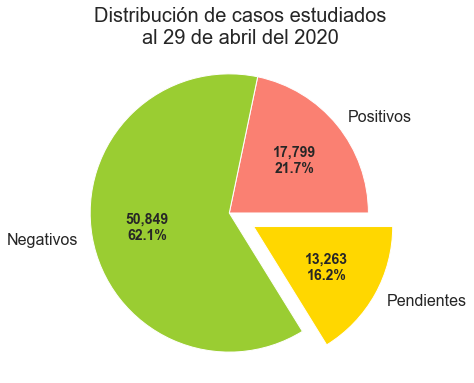

In [18]:
etiquetas = ['Positivos', 'Negativos', 'Pendientes']
valores = [len(casos_confirmados), len(casos_negativos), len(casos_pendientes)]
explode = (0, 0, 0.2)

def funcion(porcentaje, valores):
    absoluto = int(porcentaje/100.*np.sum(valores))
    return '{:,.0f}\n{:.1%}'.format(absoluto, porcentaje/100)

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.set_title('Distribución de casos estudiados\nal '+ fecha_actualizacion.strftime('%d de %B del %Y'),fontsize=20)
_, textos, autotextos =\
ax1.pie(valores, explode=explode, labels=etiquetas, autopct=lambda pct: funcion(pct, valores),
        colors=['salmon','yellowgreen','gold'],shadow=False, startangle=0)
ax1.axis('equal')
plt.setp(autotextos, size=14, weight='bold')
plt.setp(textos, size=16)

plt.show()

## Análisis de atributos relativos a la atención

### Instituciones de origen
Prácticamente el 90% de los casos confirmados fueron identificados en instituciones de salud del Gobierno Federal (Secretaría de Salud, IMSS e ISSSTE).

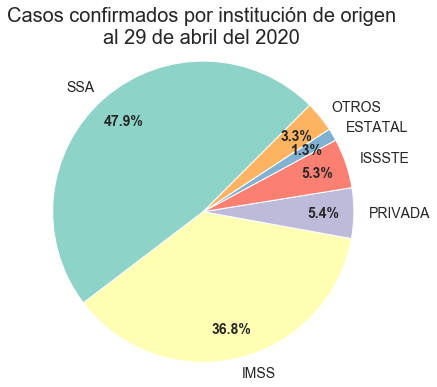

In [19]:
x = casos_confirmados['SECTOR'].value_counts()
sns.set_palette('Set3',n_colors=10)

etiquetas = [instituciones[i] for i in x.index[:5]] + ['OTROS']
valores = np.append(x.values[:5], x.sum() - x.values[:5].sum())

def funcion(porcentaje, valores):
    absoluto = int(porcentaje/100 * np.sum(valores))
    return '{:.1%}'.format(porcentaje/100)

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.set_title('Casos confirmados por institución de origen\nal '+ fecha_actualizacion.strftime('%d de %B del %Y'),fontsize=20)
_, textos, autotextos =\
ax1.pie(valores, labels=etiquetas, autopct=lambda pct: funcion(pct, valores),
        shadow=False, startangle=45, pctdistance=0.8)
ax1.axis('equal')
plt.setp(autotextos, size=14, weight='bold')
plt.setp(textos, size=14)

plt.show()

### Tipo de atención
El 60.4% de los casos confirmados han recibido atención ambulatoria, el 35.3% ha requerido hospitalización y el 4.3% ha sido intubado para recibir apoyo respiratorio (menos de 1 de cada 9 hospitalizados).

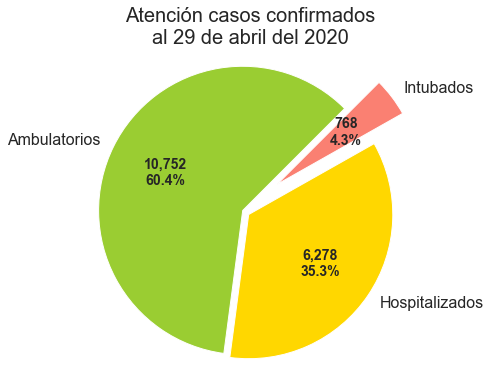

In [20]:
ambulatorios = len(casos_confirmados[casos_confirmados['TIPO_PACIENTE']==1])
hospitalizados = len(casos_confirmados[casos_confirmados['TIPO_PACIENTE']==2])
intubados = len(casos_confirmados[casos_confirmados['INTUBADO']==1])

etiquetas = ['Ambulatorios', 'Hospitalizados', 'Intubados']
valores = [ambulatorios, hospitalizados - intubados, intubados]
explode = (0, 0.05, 0.3)

def funcion(porcentaje, valores):
    absoluto = int(porcentaje/100.*np.sum(valores))
    return '{:,.0f}\n{:.1%}'.format(absoluto, porcentaje/100)

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.set_title('Atención casos confirmados\nal '+ fecha_actualizacion.strftime('%d de %B del %Y'),fontsize=20)
_, textos, autotextos =\
ax1.pie(valores, explode=explode, labels=etiquetas, autopct=lambda pct: funcion(pct, valores),
        colors=['yellowgreen','gold','salmon'],shadow=False, startangle=45)
ax1.axis('equal')
plt.setp(autotextos, size=14, weight='bold')
plt.setp(textos, size=16)

plt.show()

### Contacto con otros casos confirmados
Aunque se desconoce la información para 37.8% de los casos, casi la mitad de los casos confirmados tuvieron contacto con otro caso diagnosticado de COVID-19.

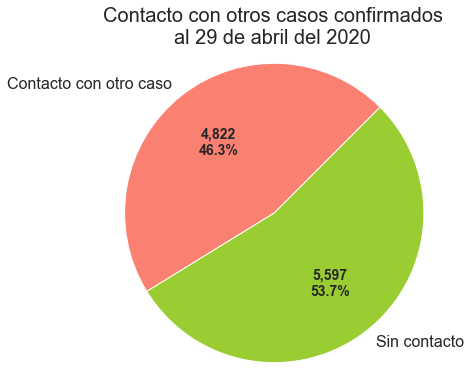

In [21]:
con_contacto = len(casos_confirmados[casos_confirmados['OTRO_CASO']==1])
sin_contacto = len(casos_confirmados[casos_confirmados['OTRO_CASO']==2])

etiquetas = ['Contacto con otro caso', 'Sin contacto']
valores = [con_contacto, sin_contacto]
explode = (0, 0)

def funcion(porcentaje, valores):
    absoluto = int(porcentaje/100.*np.sum(valores))
    return '{:,.0f}\n{:.1%}'.format(absoluto, porcentaje/100)

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.set_title('Contacto con otros casos confirmados\nal '+ fecha_actualizacion.strftime('%d de %B del %Y'),fontsize=20)
_, textos, autotextos =\
ax1.pie(valores, explode=explode, labels=etiquetas, autopct=lambda pct: funcion(pct, valores),
        colors=['salmon','yellowgreen'],shadow=False, startangle=45)
ax1.axis('equal')
plt.setp(autotextos, size=14, weight='bold')
plt.setp(textos, size=16)

plt.show()

### Evolución diaria de casos
En el agregado nacional, el numero diario de casos ingresados, de casos confirmados y de defunciones mantienen una marcada tendencia de crecimiento. El promedio móvil de 7 días de los casos confirmados por día se duplicó en 10 días y el de defunciones en 14 días.

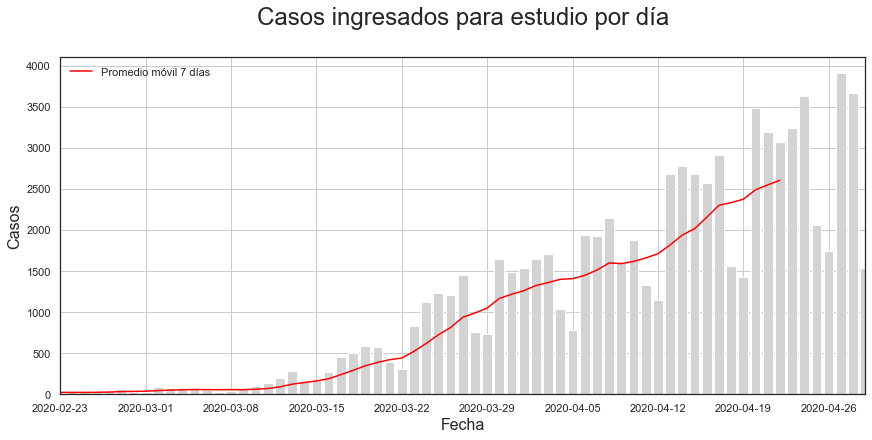

In [22]:
x = casos_totales.groupby('FECHA_INGRESO')['FECHA_INGRESO'].count()

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
ax.set_title('Casos ingresados para estudio por día\n', fontsize=24)
ax.set_ylabel('Casos', fontsize=16)
ax.set_xlabel('Fecha', fontsize=16)
ax.bar(x.index, x.values, color='lightgray')
ax.plot(x.index[:-7], x.rolling(window=7).mean()[:-7], color='red', label='Promedio móvil 7 días')
ax.set_xlim(737478,fecha_actualizacion)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.grid('True')
ax.legend(loc='upper left', frameon=False)

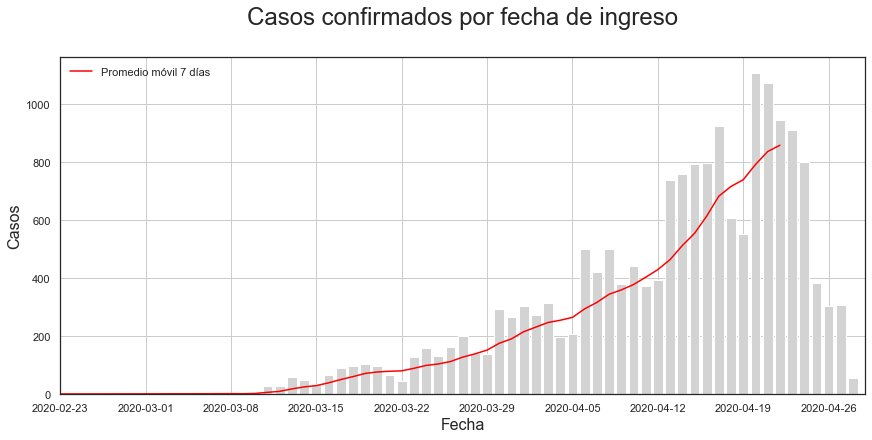

In [23]:
x = casos_confirmados.groupby('FECHA_INGRESO')['FECHA_INGRESO'].count()

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
ax.set_title('Casos confirmados por fecha de ingreso\n', fontsize=24)
ax.set_ylabel('Casos', fontsize=16)
ax.set_xlabel('Fecha', fontsize=16)
ax.bar(x.index, x.values, color='lightgray')
ax.plot(x.index[:-7], x.rolling(window=7).mean()[:-7], color='red', label='Promedio móvil 7 días')
ax.set_xlim(737478,fecha_actualizacion)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.grid('True')
ax.legend(loc='upper left', frameon=False)

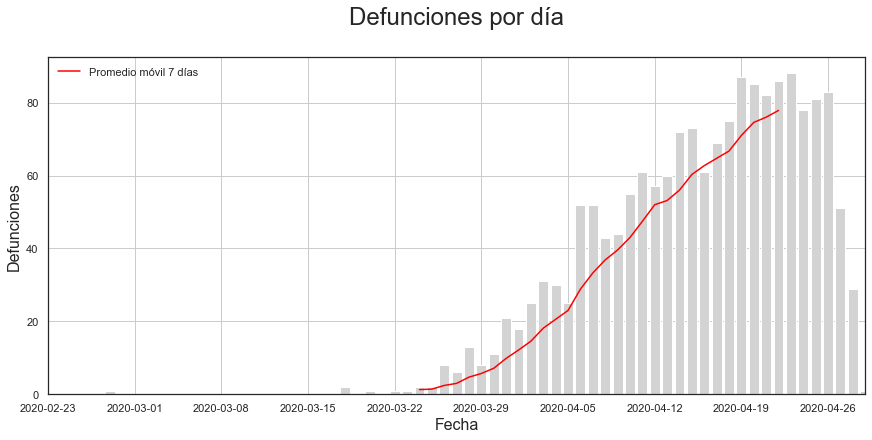

In [24]:
x = defunciones[defunciones['RESULTADO'] == 1].groupby('FECHA_DEF')['FECHA_DEF'].count()

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
ax.set_title('Defunciones por día\n', fontsize=24)
ax.set_ylabel('Defunciones', fontsize=16)
ax.set_xlabel('Fecha', fontsize=16)
ax.set_xlim(737478,fecha_actualizacion)
ax.bar(x.index, x.values, color='lightgray')
ax.plot(x.index[:-7], x.rolling(window=7).mean()[:-7], color='red', label='Promedio móvil 7 días')
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.grid('True')
ax.legend(loc='upper left', frameon=False)

### Evolución por fecha de inicio de síntomas
El número de casos confirmados por fecha de inicio de síntomas se ha cuadruplicado. Están registrados 209 casos confirmados que empezaron a mostrar síntomas el 23 de marzo de 2020, fecha de inicio de las medidas de sana distancia. El 20 de abril, 28 días después, el número de casos que empezaron a mostrar síntomas ese día fue 842. A partir del 16 de abril pareciera haber una desaceleración.

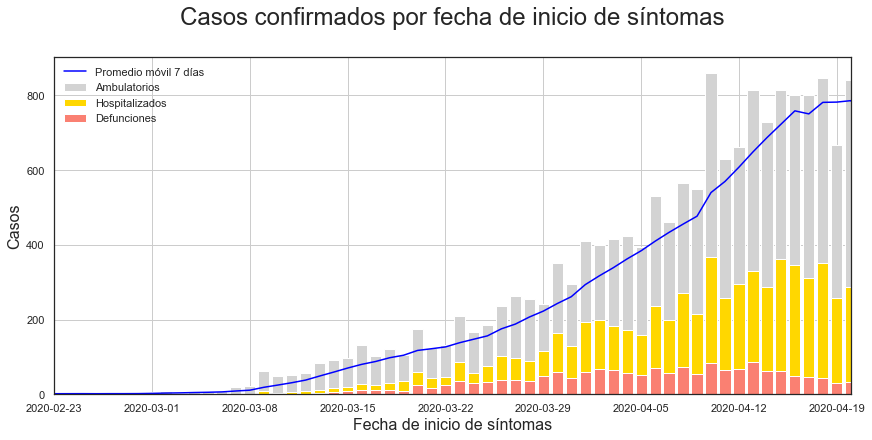

In [25]:
desfase = -9

x = casos_confirmados.groupby('FECHA_SINTOMAS')['FECHA_SINTOMAS'].count()
x1 = casos_confirmados[casos_confirmados['TIPO_PACIENTE'] == 2].\
groupby('FECHA_SINTOMAS')['FECHA_SINTOMAS'].count()
x2 = defunciones[defunciones['RESULTADO'] == 1].groupby('FECHA_SINTOMAS')['FECHA_SINTOMAS'].count()

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
ax.set_title('Casos confirmados por fecha de inicio de síntomas\n', fontsize=24)
ax.set_ylabel('Casos', fontsize=16)
ax.set_xlabel('Fecha de inicio de síntomas', fontsize=16)
ax.bar(x.index, x.values, color='lightgray', label = 'Ambulatorios')
ax.bar(x1.index, x1.values, color='gold', label = 'Hospitalizados')
ax.bar(x2.index, x2.values, color='salmon', label = 'Defunciones')
ax.plot(x.index, x.rolling(window=7).mean(), color='blue', label = 'Promedio móvil 7 días')
ax.set_xlim(737478,fecha_actualizacion - timedelta(days=-desfase))
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.grid('True')
ax.legend(loc='upper left', frameon=False)

### Distribución de casos confirmados por entidad federativa
Más de la mitad de los casos confirmados se concentran en la Ciudad de México, el Estado de México y Baja California. Otro 22% está en Tabasco, Sinaloa, Quintana Roo, Puebla, Veracruz y Yucatán. Los restantes 23 estados concentran 26% los casos.

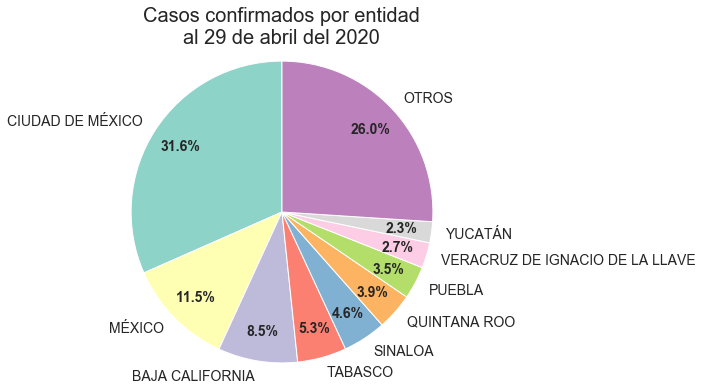

In [26]:
matriz_estados = pd.DataFrame(index=list(entidades.values())[:32],
                              columns=['Lugar en casos','Incidencia','Letalidad','Tendencia'])
x = casos_confirmados['ENTIDAD_UM'].value_counts()

# Asigna indicador de lugar en número de casos
c = 0
for estado in x.sort_values().index:
    c += 1
    matriz_estados.at[entidades[estado],'Lugar en casos'] = c

sns.set_palette('Set3',n_colors=10)

etiquetas = [entidades[i] for i in x.index[:9]] + ['OTROS']
valores = np.append(x.values[:9], x.sum() - x.values[:9].sum())

def funcion(porcentaje, valores):
    absoluto = int(porcentaje/100 * np.sum(valores))
    return '{:.1%}'.format(porcentaje/100)

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.set_title('Casos confirmados por entidad\nal '+ fecha_actualizacion.strftime('%d de %B del %Y'),fontsize=20)
_, textos, autotextos =\
ax1.pie(valores, labels=etiquetas, autopct=lambda pct: funcion(pct, valores),
       shadow=False, startangle=90, pctdistance=0.8)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.setp(autotextos, size=14, weight='bold')
plt.setp(textos, size=14)

plt.show()

### Incidencia por entidad federativa
Hay 6 estados con más de 200 casos confirmados por millón de habitantes, 18 que tienen entre 50 y 200, y 8 que tienen menos de 50 casos por millón.

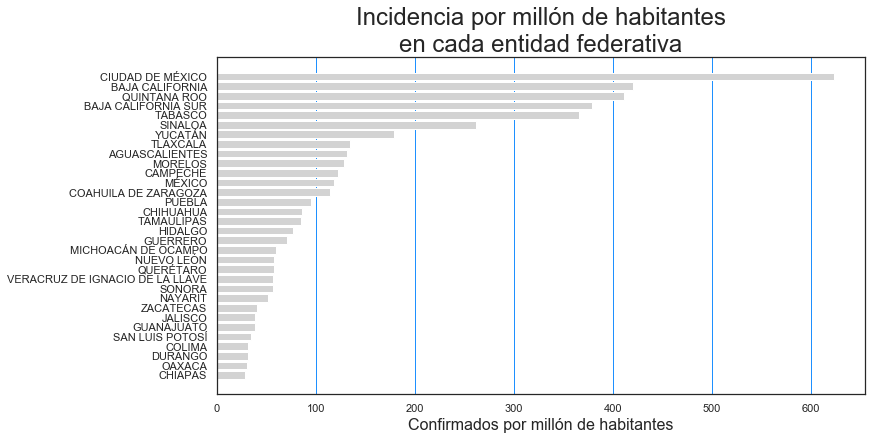

In [27]:
y = x.apply(lambda cc: cc /poblacion_entidades[x[x == cc].index[0]] * 1000000)
y.sort_values(ascending=False, inplace=True)
x1 =[entidades[i] for i in y.index]

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
ax.set_title('Incidencia por millón de habitantes\nen cada entidad federativa', fontsize=24)
ax.set_xlabel('Confirmados por millón de habitantes', fontsize=16)
ax.barh(x1, y, color='lightgray')
ax.invert_yaxis() 
ax.grid(axis='x', color='dodgerblue')

In [28]:
# Asgina indicador de incidencia (0. Baja, 1. Media, 2. Alta)
for estado in y.index:
    if y[estado] > 200:
        matriz_estados.at[entidades[estado],'Incidencia'] = 2
    elif y[estado] > 50 and y[estado] <= 200:
        matriz_estados.at[entidades[estado],'Incidencia'] = 1
    else:
        matriz_estados.at[entidades[estado],'Incidencia'] = 0
entidades_alta_incidencia = y[y.values > 200]
entidades_media_incidencia = y[(y.values <= 200) & (y.values > 50)]
entidades_baja_incidencia = y[y.values <= 50]

print('Entidades alta incidencia:', len(entidades_alta_incidencia))
print('Entidades incidencia media:', len(entidades_media_incidencia))
print('Entidades baja incidencia:', len(entidades_baja_incidencia))

Entidades alta incidencia: 6
Entidades incidencia media: 18
Entidades baja incidencia: 8


### Letalidad por entidad federativa
Hay 8 estados que tienen una tasa de letalidad (defunciones entre casos confirmados) mayor a dos veces el promedio mundial, 18 con una tasa de 1 a 2 veces el promedio mundial, y 6 estados con una tasa de letalidad menor al promedio mundial.

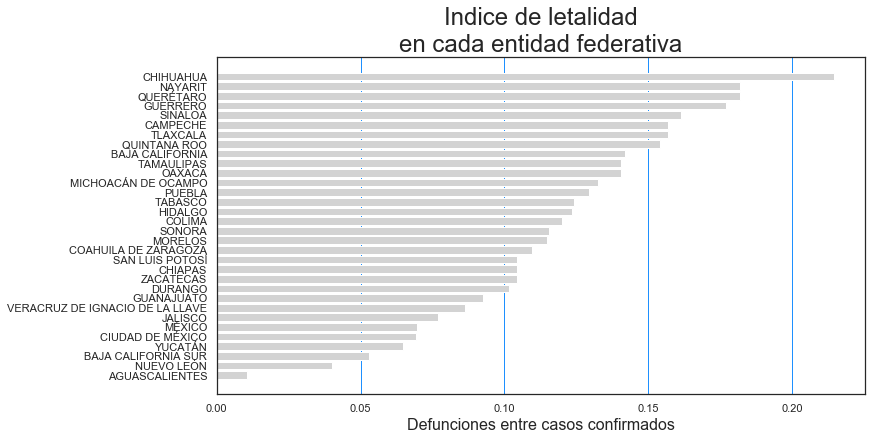

In [29]:
y1 = defunciones[defunciones['RESULTADO'] == 1]['ENTIDAD_UM'].value_counts().astype('float')
y = y1.apply(lambda f: f / x[y1[y1 == f].index[0]])
y.sort_values(ascending=False, inplace=True)
x1 = [entidades[i] for i in y.index]

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
ax.set_title('Indice de letalidad\nen cada entidad federativa', fontsize=24)
ax.set_xlabel('Defunciones entre casos confirmados', fontsize=16)
ax.barh(x1, y, color='lightgray')
ax.invert_yaxis() 
ax.grid(axis='x', color='dodgerblue')

In [30]:
# Asgina indicador de letalidad (0. Baja, 1. Media, 2. Alta)
letalidad_mundial = 227623 / 3193165
for estado in y.index:
    if y[estado] > letalidad_mundial * 2:
        matriz_estados.at[entidades[estado],'Letalidad'] = 2
    elif y[estado] > letalidad_mundial and y[estado] <= letalidad_mundial * 2:
        matriz_estados.at[entidades[estado],'Letalidad'] = 1
    else:
        matriz_estados.at[entidades[estado],'Letalidad'] = 0
entidades_alta_letalidad = y[y.values > letalidad_mundial * 2]
entidades_media_letalidad = y[(y.values <= letalidad_mundial * 2) & (y.values > letalidad_mundial)]
entidades_baja_letalidad = y[y.values <= letalidad_mundial]

print('Entidades alta letalidad:', len(entidades_alta_letalidad))
print('Entidades letalidad media:', len(entidades_media_letalidad))
print('Entidades baja letalidad:', len(entidades_baja_letalidad))

Entidades alta letalidad: 8
Entidades letalidad media: 18
Entidades baja letalidad: 6


### Tendencias por entidad federativa
De los seis estados con alta incidencia, la ciudad de México muestra un crecimiento importante del promedio móvil de 7 días de casos confirmados por fecha de inicio de síntomas. Baja California y Baja California Sur presentan una reducción, en tanto que Quintana Roo, Sinaloa y Tabasco muestran cierta desaceleración.

In [31]:
def IndiceCrecimiento(valores):
    """ Asigna un indicador de tendencia a un vector de datos de promedio móvil.
        4. Alza importante. Crecimiento de más de 100% del promedio móvil
           en 14 días (Se duplica en menos de 14 días).
        3. Alza moderada. Crecimiento entre 41 y 100% del promedio móvil
           en 14 días (Se duplica en menos de 28 días).
        2. Estable. Crecimiento de menos de 41% del promedio móvil en 14 días o
           reducción de hasta 29% respecto al promedio móvil máximo
           (no hay cambios significativos en menos de 28 díass).
        1. Baja moderada. Reducción de entre 29 y 50% respecto al promedio móvil
           máximo (Se reduce a la mitad en menos de 28 días).
        0. Baja importante. Reducción de más de 50% respecto al promedio móvil
           máximo (Se reduce a la mitad en menos de 14 días)."""
    
    ultima_fecha = min(datetime.date(valores.index[-1]), fecha_actualizacion - timedelta(days=-desfase))
    if ultima_fecha not in valores.index:
        for indice in valores.index:
            if indice < ultima_fecha:
                siguiente = indice
            else:
                break
        ultima_fecha = datetime.date(siguiente)
    vector = valores.dropna()[:ultima_fecha]
    referencia = vector[ultima_fecha]
        
    if (ultima_fecha - datetime.date(vector.index[0])) < timedelta(days=14):
        periodo = datetime.date(vector.index[0])
    else:
        if (ultima_fecha - timedelta(days=14)) not in vector.index:
            for indice in vector.index:
                if indice < (ultima_fecha - timedelta(days=14)):
                    siguiente = indice
                else:
                    break
            periodo = datetime.date(siguiente)
        else:
            periodo = ultima_fecha - timedelta(days=14)
    if referencia == vector.max():
        if referencia / vector[periodo] > 2:
            indice = 4
        elif referencia / vector[periodo] > 1.41:
            indice = 3
        else:
            indice = 2
    else:
        if referencia / vector.max() < 0.5:
            indice = 0
        elif referencia / vector.max() < 0.71:
            indice = 1
        else:
            indice = 2
    return indice

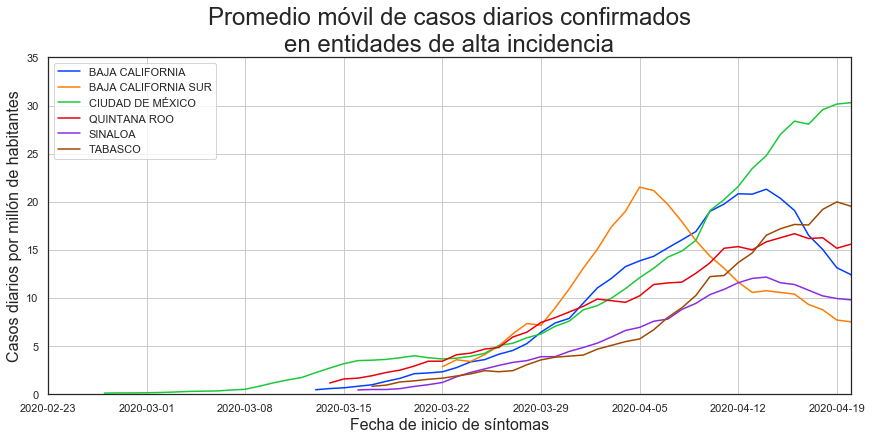

In [32]:
confirmados_estados = casos_confirmados.groupby(['ENTIDAD_UM','FECHA_SINTOMAS'])['FECHA_SINTOMAS'].count()
sns.set_palette('bright',6,1)

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
ax.set_title('Promedio móvil de casos diarios confirmados\nen entidades de alta incidencia', fontsize=24)
ax.set_ylabel('Casos diarios por millón de habitantes', fontsize=16)
ax.set_xlabel('Fecha de inicio de síntomas', fontsize=16)

for estado in set(entidades_alta_incidencia.index):
    x1 = confirmados_estados[estado].apply(lambda cc: cc / poblacion_entidades[estado] * 1000000)
    y = x1.rolling(window=7).mean()
    matriz_estados.at[entidades[estado],'Tendencia'] = IndiceCrecimiento(y)
    ax.plot(x1.index, y, label=entidades[estado])
ax.legend()

ax.set_xlim(737478,fecha_actualizacion - timedelta(days=-desfase))
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.set_ylim(0,35)
ax.grid('True')

plt.show()

De los 18 estados con incidencia media, sólo Coahuila, Nuevo León y Sonora muestran una tendencia a la baja del promedio móvil de 7 días de casos confirmados por fecha de inicio de síntomas. Aguascalientes, Chihuahua, Michoacán, Morelos, Guerrero, Hidalgo, Tlaxcala, Veracruz y Yucatán muestran una tendencia al alza. Campeche, Estado de México, Nayarit, Puebla, Querétaro y Tamaulipas mantienen cierta estabilidad.

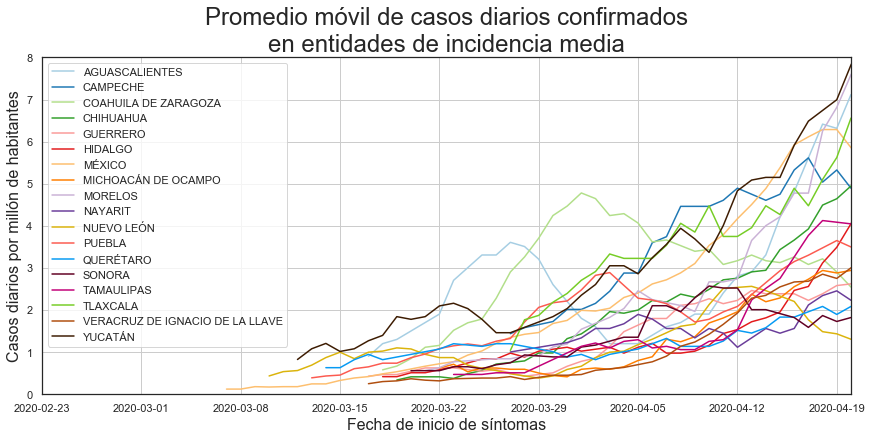

In [33]:
colores = ['gold','coral','azure','burgundy','magenta','apple green','burnt sienna','chocolate']
paleta = sns.color_palette('Paired', 10) + sns.color_palette(sns.xkcd_palette(colores))
sns.set_palette(paleta)

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
ax.set_title('Promedio móvil de casos diarios confirmados\nen entidades de incidencia media', fontsize=24)
ax.set_ylabel('Casos diarios por millón de habitantes', fontsize=16)
ax.set_xlabel('Fecha de inicio de síntomas', fontsize=16)

for estado in set(entidades_media_incidencia.index):
    x1 = confirmados_estados[estado].apply(lambda cc: cc / poblacion_entidades[estado] * 1000000)
    y = x1.rolling(window=7).mean()
    matriz_estados.at[entidades[estado],'Tendencia'] = IndiceCrecimiento(y)
    ax.plot(x1.index, y, label=entidades[estado])
ax.legend()

ax.set_xlim(737478,fecha_actualizacion - timedelta(days=-desfase))
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.set_ylim(0,8)
ax.grid('True')

plt.show()

De los 8 estados con baja incidencia, Chiapas, Guanajuato, Jalisco, Oaxaca y Zacatecas muestran un crecimiento importante del promedio móvil de 7 días de casos confirmados por fecha de inicio de síntomas. Colima, Durango y San Luis Potosí mantienen cierta estabilidad.

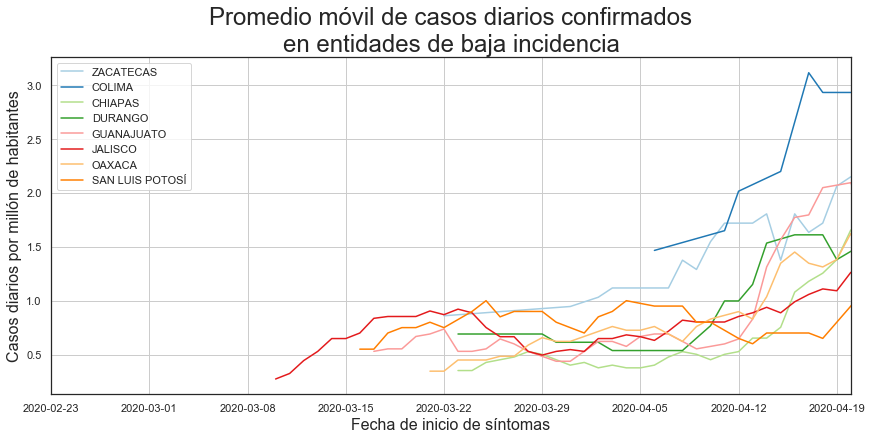

In [34]:
sns.set_palette(paleta)

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
ax.set_title('Promedio móvil de casos diarios confirmados\nen entidades de baja incidencia', fontsize=24)
ax.set_ylabel('Casos diarios por millón de habitantes', fontsize=16)
ax.set_xlabel('Fecha de inicio de síntomas', fontsize=16)

for estado in set(entidades_baja_incidencia.index):
    x1 = confirmados_estados[estado].apply(lambda cc: cc / poblacion_entidades[estado] * 1000000)
    y = x1.rolling(window=7).mean()
    matriz_estados.at[entidades[estado],'Tendencia'] = IndiceCrecimiento(y)
    ax.plot(x1.index, y, label=entidades[estado])
ax.legend()

ax.set_xlim(737478,fecha_actualizacion - timedelta(days=-desfase))
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.grid('True')

plt.show()

In [35]:
matriz_estados['Ranking'] = matriz_estados['Lugar en casos'] / matriz_estados['Lugar en casos'].max() +\
                            matriz_estados['Incidencia'] + matriz_estados['Letalidad'] + matriz_estados['Tendencia']
matriz_estados.sort_values(by='Ranking', ascending=False, inplace=True)
matriz_estados['Lugar en casos'] = 33 - matriz_estados['Lugar en casos']
matriz_estados['Incidencia'].replace({2:'Alta',1:'Media',0:'Baja'}, inplace=True)
matriz_estados['Letalidad'].replace({2:'Alta',1:'Media',0:'Baja'}, inplace=True)
matriz_estados['Tendencia'].replace({4:'Alza importante', 3:'Alza moderada',
                                     2:'Estable', 1:'Baja moderada', 0:'Baja importante'}, inplace=True)

A continuación se presenta una matriz que sintetiza los indicadores por estado. Están ordenados para empezar por los valores más negativos.

In [36]:
matriz_estados.drop(['Ranking'], axis=1)

,Lugar en casos,Incidencia,Letalidad,Tendencia
CHIHUAHUA,11,Media,Alta,Alza importante
TLAXCALA,22,Media,Alta,Alza importante
CIUDAD DE MÉXICO,1,Alta,Baja,Alza importante
SINALOA,5,Alta,Alta,Estable
QUINTANA ROO,6,Alta,Alta,Estable
VERACRUZ DE IGNACIO DE LA LLAVE,8,Media,Media,Alza importante
MICHOACÁN DE OCAMPO,16,Media,Media,Alza importante
MORELOS,17,Media,Media,Alza importante
GUERRERO,18,Media,Alta,Alza moderada
HIDALGO,20,Media,Media,Alza importante


## Análisis atributos sociodemográficos
Se fijan los valores de referencia de distribución de la población con datos del conteo intercensal 2015 del INEGI.

https://www.inegi.org.mx/temas/estructura/default.html#Informacion_general

In [37]:
poblacion_por_edad = [18.0, 18.4, 16.6, 14.6, 12.6, 9.2, 5.7, 3.2, 1.6]
poblacion_por_sexo = [48.6, 51.4]

### Distribución de casos confirmados por sexo
Al 29 de abril de 2020 se presenta una incidencia mayor de casos entre los hombres, pues representan el 58% de los casos y sólo el 49% de la población.

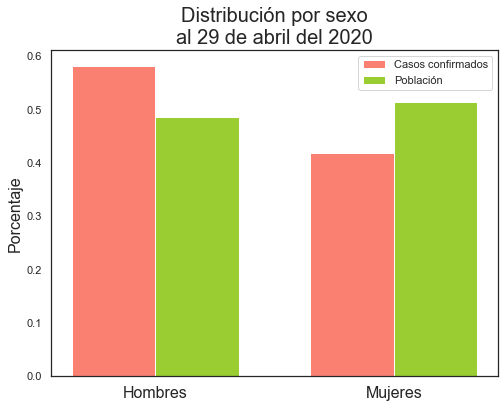

In [38]:
n = 2
valores = casos_confirmados['SEXO'].value_counts().values / len(casos_confirmados)

ind = np.arange(n)
ancho = 0.35

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, valores, ancho, color='salmon')
rects2 = ax.bar(ind + ancho, np.array(poblacion_por_sexo) / 100, ancho, color='yellowgreen')

ax.set_ylabel('Porcentaje', fontsize=16)
ax.set_title('Distribución por sexo\nal '+ fecha_actualizacion.strftime('%d de %B del %Y'),fontsize=20)
ax.set_xticks(ind + ancho / 2)
ax.set_xticklabels( ('Hombres', 'Mujeres'), fontsize=16)

ax.legend((rects1[0],rects2[0]),('Casos confirmados', 'Población'))

plt.show()

### Distribución de casos confirmados por edad
Al 29 de abril de 2020 se presenta una incidencia mayor de casos entre los mayores de 20 años. Los mexicanos menores de 20 años representan el 36.4% de la población, pero sólo el 2.2% de los casos confirmados.

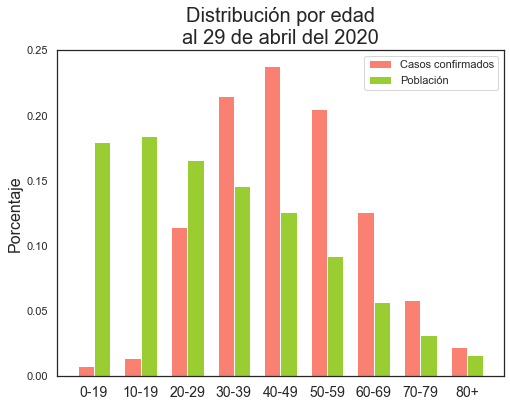

In [39]:
distribucion_edad = pd.cut(casos_confirmados['EDAD'], bins=[0] + [9 + i*10 for i in range(0,9)]).value_counts(sort=False)
indices = list(distribucion_edad.index)
distribucion_edad[indices[0]] += len(casos_confirmados[casos_confirmados['EDAD'] == 0])
distribucion_edad[indices[-1]] += len(casos_confirmados[casos_confirmados['EDAD'] > 89])

n = len(distribucion_edad)
valores = distribucion_edad.values / distribucion_edad.sum()
ind = np.arange(n)
ancho = 0.35

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, valores, ancho, color='salmon')
rects2 = ax.bar(ind + ancho, np.array(poblacion_por_edad) / 100, ancho, color='yellowgreen')

ax.set_ylabel('Porcentaje', fontsize=16)
ax.set_title('Distribución por edad\nal '+ fecha_actualizacion.strftime('%d de %B del %Y'),fontsize=20)
ax.set_xticks(ind + ancho / 2)
ax.set_xticklabels(['0-19','10-19','20-29','30-39','40-49','50-59','60-69','70-79', '80+'], fontsize=14)

ax.legend((rects1[0],rects2[0]),('Casos confirmados', 'Población'))

plt.show()

### Porcentaje de habla indígena
Al 29 de abril, el 1.5% de los casos confirmados declaran hablar alguna lengua indígena.

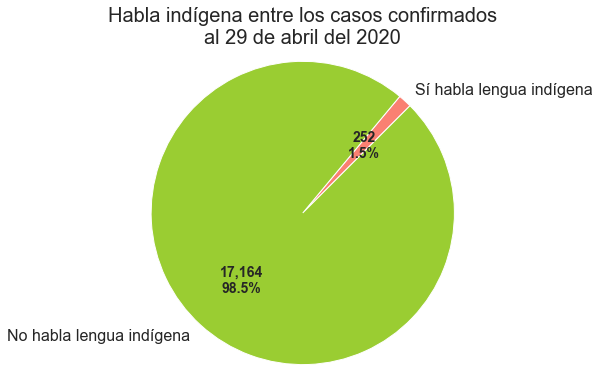

In [40]:
etiquetas = ['Sí habla lengua indígena', 'No habla lengua indígena']
valores = [(casos_confirmados['HABLA_LENGUA_INDIG'] == 1).sum(), (casos_confirmados['HABLA_LENGUA_INDIG'] == 2).sum()]

explode = (0, 0)

def funcion(porcentaje, valores):
    absoluto = int(porcentaje/100.*np.sum(valores))
    return '{:,.0f}\n{:.1%}'.format(absoluto, porcentaje/100)

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.set_title('Habla indígena entre los casos confirmados\nal '+ fecha_actualizacion.strftime('%d de %B del %Y'),fontsize=20)
_, textos, autotextos =\
ax1.pie(valores, explode=explode, labels=etiquetas, autopct=lambda pct: funcion(pct, valores),
        colors=['salmon','yellowgreen'],shadow=False, startangle=45)
ax1.axis('equal')
plt.setp(autotextos, size=14, weight='bold')
plt.setp(textos, size=16)

plt.show()

### Distribución por nacionalidad
Al 29 de abril el 98.9% de los casos confirmados declaran tener nacionalidad mexicana.

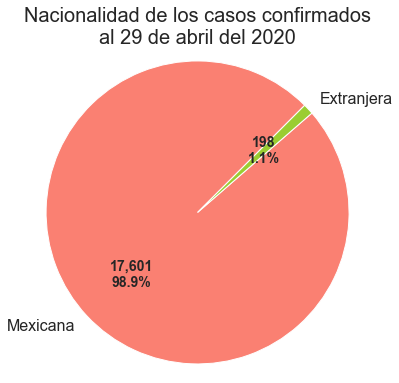

In [41]:
etiquetas = ['Mexicana', 'Extranjera']
valores = [(casos_confirmados['NACIONALIDAD'] == 1).sum(), (casos_confirmados['NACIONALIDAD'] == 2).sum()]

explode = (0, 0)

def funcion(porcentaje, valores):
    absoluto = int(porcentaje/100.*np.sum(valores))
    return '{:,.0f}\n{:.1%}'.format(absoluto, porcentaje/100)

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.set_title('Nacionalidad de los casos confirmados\nal '+ fecha_actualizacion.strftime('%d de %B del %Y'),fontsize=20)
_, textos, autotextos =\
ax1.pie(valores, explode=explode, labels=etiquetas, autopct=lambda pct: funcion(pct, valores),
        colors=['salmon','yellowgreen'],shadow=False, startangle=45)
ax1.axis('equal')
plt.setp(autotextos, size=14, weight='bold')
plt.setp(textos, size=16)

plt.show()

## Análisis atributos de comorbilidad
Al 29 de abril de 2020, la principal condición adicional a la COVID-19 registrada en los casos confirmados ambulatorios, hospitalizados e intubados, así como en las defunciones, es la neumonía. Después vienen la diabetes, la hipertensión y la obesidad. Las otras condiciones registradas tienen una presencia sustancialmente menor.
La neumonía, la diabetes, la hipertensión, la insuficiencia renal crónica y la enfermedad pulmonar obstructiva crónica (EPOC) incrementan de manera importante su presencia en los pacientes hospitalizados e intubados, así como en las defunciones.

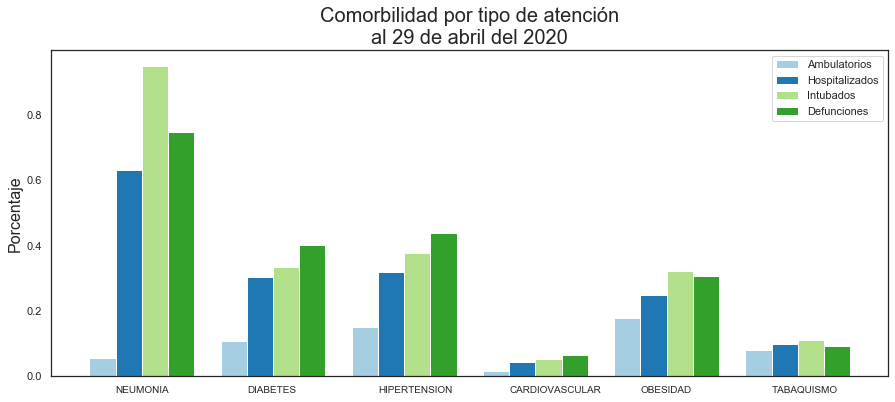

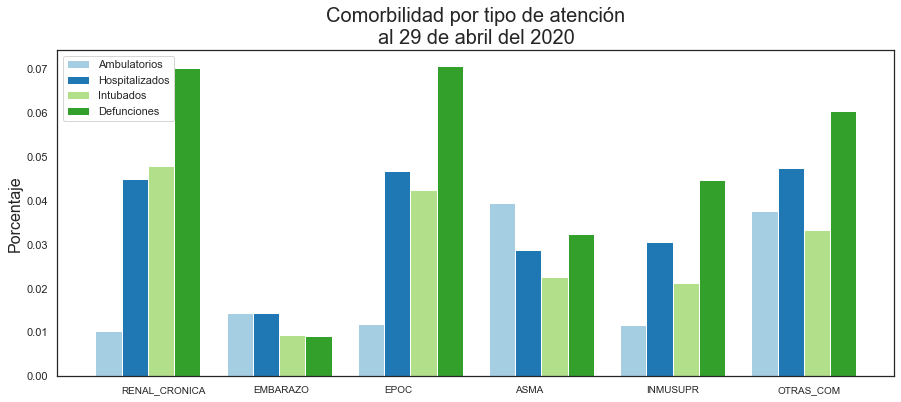

In [42]:
lista_atributos = []
lista_atributos.append(['NEUMONIA','DIABETES','HIPERTENSION','CARDIOVASCULAR','OBESIDAD','TABAQUISMO'])
lista_atributos.append(['RENAL_CRONICA','EMBARAZO','EPOC','ASMA','INMUSUPR','OTRAS_COM'])

def Comorbilidad(x, y):
    comorbilidad = []
    for atributo in y:
        porcentaje = x[x[atributo] == 1][atributo].count()\
        / x[(x[atributo] == 1) | (x[atributo] == 2)][atributo].count()
        comorbilidad.append(porcentaje)
    return comorbilidad
    
for lista in lista_atributos:
    casos = casos_confirmados[casos_confirmados['TIPO_PACIENTE']==1]
    comorbilidad_ambulatorios = Comorbilidad(casos, lista)
    
    casos = casos_confirmados[(casos_confirmados['TIPO_PACIENTE']==2) & (casos_confirmados['INTUBADO']!=1)]
    comorbilidad_hospitalizados = Comorbilidad(casos, lista)

    casos = casos_confirmados[casos_confirmados['INTUBADO']==1]
    comorbilidad_intubados = Comorbilidad(casos, lista)

    casos = defunciones[defunciones['RESULTADO']==1]
    comorbilidad_defunciones = Comorbilidad(casos, lista)

    n = 6
    ind = np.arange(n)
    ancho = 0.2

    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    ax.bar(ind, comorbilidad_ambulatorios, ancho, label='Ambulatorios')
    ax.bar(ind + ancho, comorbilidad_hospitalizados, ancho, label='Hospitalizados')
    ax.bar(ind + 2 * ancho, comorbilidad_intubados, ancho, label='Intubados')
    ax.bar(ind + 3 * ancho, comorbilidad_defunciones, ancho, label='Defunciones')

    ax.set_ylabel('Porcentaje', fontsize=16)
    ax.set_title('Comorbilidad por tipo de atención\nal '+ fecha_actualizacion.strftime('%d de %B del %Y'),fontsize=20)
    ax.set_xticks(ind + ancho / 2)
    ax.set_xticklabels(lista, fontsize=10, ha='left')
    ax.legend()

    plt.show()

## Conclusiones
A un mes de la implantación de las medidas de distanciamiento social, no hay señales de que pueda haber pronto una reanudación generalizada de actividades en México. A nivel nacional sigue creciendo el número de casos nuevos por día que ingresan al sistema de salud, aunque parece haber cierta desaceleración en el número de casos por fecha de inicio de síntomas a partir del 16 de abril.

A nivel estatal sólo cinco entidades muestran una disminución en el número de casos nuevos por fecha de inicio de síntomas (Baja California, Baja California Sur, Coahuila, Nuevo León y Sonora). En el resto de las entidades están creciendo todavía los casos nuevos por día.

Dada la concentración de la población en las zonas urbanas, seguramente un análisis a nivel municipal llevaría a que hay cientos de municipios en los que no hay una incidencia o crecimiento importante en el número de casos, o aún algunos en los que no se están presentando casos nuevos.

No obstante, me parece que ello no modifica de manera sustancial estas conclusiones. Los municipios no tienen una vida aislada y tienden a mantener una relación con otros municipios más grandes, donde continúa el contagio. Por otro lado, es en los municipios y alcaldías importantes donde se concentra la mayoría de la población y la vida económica del país, por lo que habrá que esperar a que haya señales importantes en ellos para pensar en regresar a la vida normal como nación.